In [1]:
!apt update
!apt-get install libglu1 -y
!pip install kornia_moons --upgrade
!pip install opencv-python
!pip install opencv-contrib-python
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install pydegensac

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [859 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [25.8 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1646 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1027 kB]33m
Get:10 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1275 kB]
Get:13 http://archive.ubuntu.com/ubuntu 

In [2]:
!pip install git+https://github.com/kornia/kornia

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-uicvmt8o
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-uicvmt8o
  Resolved https://github.com/kornia/kornia to commit 78f09ed4b5d6111cea3fe253f4b751d0e7aa5b3b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [3]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=2be5c357c3b7dd19bcd2abcf36cbafdc8d7cb2c40c6deeb6a97989f597032412
  Stored in directory: /tmp/pip-ephem-wheel-cache-az_r45n2/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils


In [10]:
import pydegensac
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *
from ipywidgets import FloatProgress
import time
import imutils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def resize(scale,img):
    scale_percent = scale  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized

def load_torch_image(fname,s, rot=0):
    img= cv2.imread(fname)
    if rot!=0:
        img = imutils.rotate_bound(img, rot)
    img=resize(s,img)
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    img=img.to(device)
    return img

def iterRot(rotImgs=[],img2=None):
    acc=[0,0,0,0]
    true_inliers=[]
    true_mkpoints=[]
    #rotImgs=rotImgs if rotImgs != [] else [load_torch_image(img1Dir,25,a*90) for a in range(4)]
    for t in range(4):
        print(f'{t*90} deg:',end=' ')
        tstImg = rotImgs[t]
        quadImg = img2#load_torch_image(img2Dir,30)
        matcher = KF.LoFTR(pretrained='outdoor')
        matcher = matcher.eval().cuda()
        input_dict = {"image0": K.color.rgb_to_grayscale(tstImg), # LofTR works on grayscale images only 
                      "image1": K.color.rgb_to_grayscale(quadImg)}
        with torch.no_grad():
            correspondences = matcher(input_dict)
        filtParams=[torch.count_nonzero(correspondences['confidence']>0.5),torch.mean(correspondences['confidence'])]
        print(f"PtsWConf>0.5: {filtParams[0]};", end=' ')
        print(f"avgConf: {filtParams[1]:.3f};", end=' ')
        if(filtParams[1]<0.35):
            true_inliers.append([])
            true_mkpoints.append([])
            print()
            continue
        mkpts0 = correspondences['keypoints0'].cpu().numpy()
        mkpts1 = correspondences['keypoints1'].cpu().numpy()
        true_mkpoints.append([mkpts0, mkpts1])
        H1, inliers1 = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.9999, 100000)
        inliers1 = inliers1 > 0
        H2, inliers2 = pydegensac.findFundamentalMatrix(mkpts0, mkpts1, 0.4)
        print(f'USAC match: {np.count_nonzero(inliers1 == True)};', end=' ')
        print(f'DEGENSAC match: {np.count_nonzero(inliers2 == True)};', end=' ')
        inliers_i= []
        for i,k in enumerate(inliers1):
            if(k[0]==True and inliers2[i]==True):
                inliers_i.append(True)
                acc[t]+=1
            else:
                inliers_i.append(False)
        print(f'Acc match: {acc[t]};')
        true_inliers.append(inliers_i)
        if acc[t]>20:
            break
    return acc,true_mkpoints, true_inliers
def quadIter(img1List=[], img2List=[]):
    prt_acr=[]
    prt_mkpts=[]
    prt_inliers=[]
    for q in range(4):
        print(f'QUADRANT {q+1}:')
        start2=time.time()
        #fname2 = '../../Data/NewLSTemplates/newLS_sat_'+str(q)+'-4_highQ.png'#'rectified.jpg'
        n_acr,n_mkpts,n_inliers=iterRot(img1List,mapImg[q])
        prt_acr.extend(n_acr)
        prt_mkpts+=n_mkpts
        prt_inliers+=n_inliers
        print(f'Time after time for Q{q+1}: {time.time()-start2}')
    return prt_acr, prt_mkpts, prt_inliers

def subdivisions(img2Dir, scale=25):
    image = cv2.imread(img2Dir)
    (h, w) = image.shape[:2]
    # compute the center coordinate of the image
    (cX, cY) = (w // 2, h // 2)
    #cv2.imshow('Original', image)
    imgs=[image[0:cY, 0:cX],image[0:cY, cX:w],image[cY:h, 0:cX],image[cY:h, cX:w]]
    new_imgs=[]
    for i,k in enumerate(imgs):
        new_imgs.append(resize(scale,k))
        new_imgs[i]=K.image_to_tensor(new_imgs[i], False).float() /255.
        new_imgs[i]=K.color.bgr_to_rgb(new_imgs[i])
        new_imgs[i]=new_imgs[i].to(device)
    return new_imgs


In [15]:
start=time.time()
fname1 = '../../Data/3D_sim_tests/newLS_drone_3Drot_2_highQ.png'
fname2= '../../Data/NewLSTemplates/newLS_sat_highQ.png'
vidImg=[load_torch_image(fname1,25,a*90) for a in range(4)]
mapImg=subdivisions(fname2,30)
p_acr, p_mkpts, p_inliers=quadIter(vidImg, mapImg)
f=p_acr.index(max(p_acr))    
f_img1 = vidImg[f-int(f/4)*4]
f_img2 = mapImg[int(f/4)]
f_inliers=np.array(p_inliers[f])
f_mkpts0=np.array(p_mkpts[f][0])
f_mkpts1=np.array(p_mkpts[f][1])

print(f'The final countdown: {time.time()-start}')

QUADRANT 1:
0 deg: 

/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % 

PtsWConf>0.5: 14; avgConf: 0.346; 
90 deg: PtsWConf>0.5: 10; avgConf: 0.343; 
180 deg: PtsWConf>0.5: 3; avgConf: 0.311; 
270 deg: PtsWConf>0.5: 18; avgConf: 0.357; USAC match: 17; DEGENSAC match: 14; Acc match: 1;
Time after time for Q1: 4.253042697906494
QUADRANT 2:
0 deg: PtsWConf>0.5: 9; avgConf: 0.341; 
90 deg: PtsWConf>0.5: 7; avgConf: 0.348; 
180 deg: PtsWConf>0.5: 10; avgConf: 0.336; 
270 deg: PtsWConf>0.5: 12; avgConf: 0.323; 
Time after time for Q2: 3.3244786262512207
QUADRANT 3:
0 deg: PtsWConf>0.5: 9; avgConf: 0.324; 
90 deg: PtsWConf>0.5: 12; avgConf: 0.354; USAC match: 14; DEGENSAC match: 12; Acc match: 5;
180 deg: PtsWConf>0.5: 5; avgConf: 0.328; 
270 deg: PtsWConf>0.5: 8; avgConf: 0.342; 
Time after time for Q3: 4.092686176300049
QUADRANT 4:
0 deg: PtsWConf>0.5: 7; avgConf: 0.314; 
90 deg: PtsWConf>0.5: 8; avgConf: 0.313; 
180 deg: PtsWConf>0.5: 20; avgConf: 0.343; 
270 deg: PtsWConf>0.5: 38; avgConf: 0.415; USAC match: 37; DEGENSAC match: 29; Acc match: 19;
Time after t

In [16]:
print(f'Winner: {f} --> Quadrant {int(f/4)+1}')
print(len(f_mkpts1))
print(len(f_inliers))
print(p_acr)

Winner: 15 --> Quadrant 4
131
131
[0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 19]


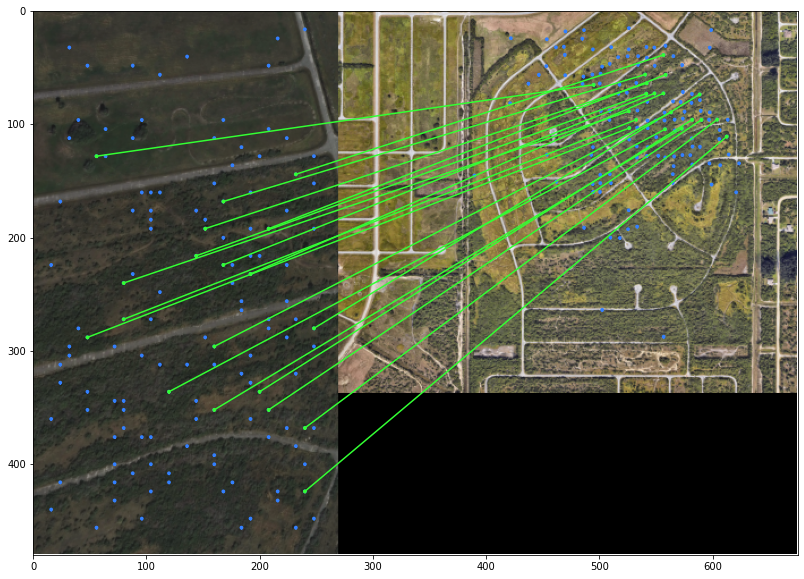

In [17]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(f_mkpts0).view(1,-1, 2),
                                torch.ones(f_mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(f_mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(f_mkpts1).view(1,-1, 2),
                                torch.ones(f_mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(f_mkpts1.shape[0]).view(1,-1, 1)),
    torch.arange(f_mkpts0.shape[0]).view(-1,1).repeat(1,2),
    K.tensor_to_image(f_img1),
    K.tensor_to_image(f_img2),
    f_inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': (0.2, 0.5, 1), 'vertical': False})

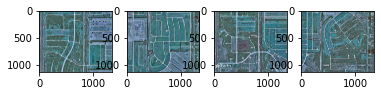

In [67]:
#IMAGE DIVIDER
image = cv2.imread('../../Data/NewLSTemplates/newLS_sat_highQ.png')
(h, w) = image.shape[:2]
# compute the center coordinate of the image
(cX, cY) = (w // 2, h // 2)
#cv2.imshow('Original', image)
imgs=[image[0:cY, 0:cX],image[0:cY, cX:w],image[cY:h, 0:cX],image[cY:h, cX:w]]
new_imgs=[]
for i in imgs:
    i=resize(30,i)
    i=K.image_to_tensor(i, False).float() /255.
    i=K.color.bgr_to_rgb(i)

plt.subplot(1, 4, 1)
plt.imshow(imgs[0])
plt.subplot(1, 4, 2)
plt.imshow(imgs[1])
plt.subplot(1, 4, 3)
plt.imshow(imgs[2])
plt.subplot(1, 4, 4)
plt.imshow(imgs[3])
#cv2.imshow("Bottom Right Corner", bottomLeft)
#cv2.imshow("Bottom Left Corner", bottomRight)
#cv2.waitKey(0)


In [98]:
uTest=subdivisions()
type(uTest[0])

torch.Tensor

In [77]:
fname1 = '../../Data/3D_sim_tests/newLS_drone_3Drot1_180_highQ.png'
vidImg=[load_torch_image(fname1,25,a*90) for a in range(4)]
type(vidImg[0])

torch.Tensor